## Importing required libraries

In [1]:
import snowflake.connector
import pandas as pd
import plotly.express as px
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

## connecting to snowflake and getting the data for IBM, MSFT, INTC and ORCL stocks (each stored in a separate table)

In [2]:
connection_params = {
    "user": "",
    "password": "",
    "account": "",
    "database": "intraday_stock",
    "schema": "processed_data"
}


table_names = ["table_IBM", "table_INTC", "table_MSFT", "table_ORCL"]

conn = snowflake.connector.connect(**connection_params)

dfs = {}

for table_name in table_names:
    query = f'SELECT * FROM "{table_name}"'
    
    cur = conn.cursor()
    cur.execute(query)
    
    dfs[table_name] = cur.fetch_pandas_all()

conn.close()

## EDA:

## 1.What is the distribution of intraday daily returns for each stock?

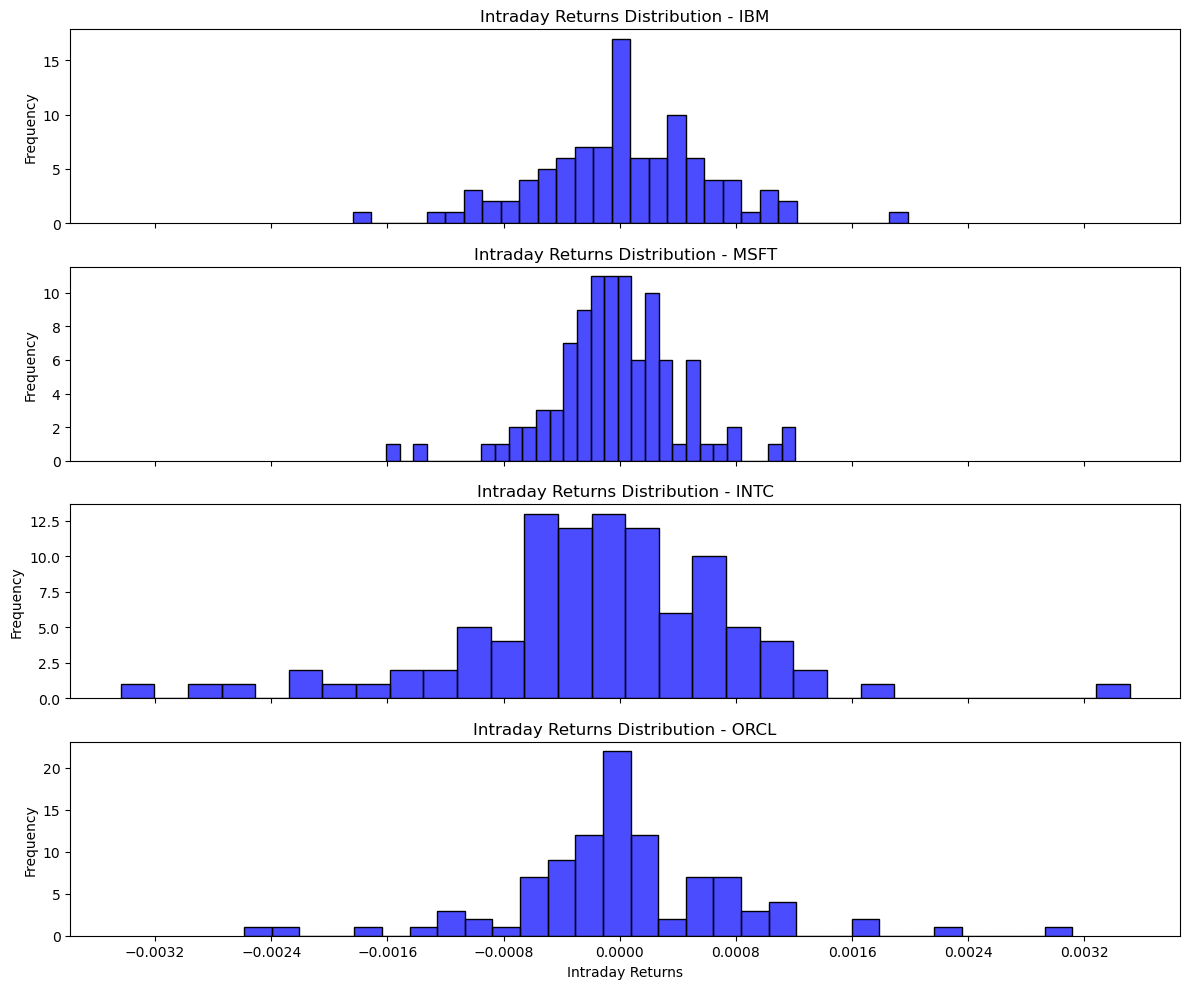

In [3]:
df_list = [dfs['table_IBM'], dfs['table_MSFT'], dfs['table_INTC'], dfs['table_ORCL']]

fig, axes = plt.subplots(nrows=len(df_list), ncols=1, figsize=(12, 10), sharex=True)

for i, (df, symbol) in enumerate(zip(df_list, ['IBM', 'MSFT', 'INTC', 'ORCL'])):
    ax = axes[i]
    sns.histplot(df['daily_return'].dropna(), bins=30, color='blue', alpha=0.7, ax=ax)
    ax.set_title(f'Intraday Returns Distribution - {symbol}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Intraday Returns') 
    ax.xaxis.set_major_locator(plt.MaxNLocator(10)) 
    
axes[-1].set_xlabel('Intraday Returns')
plt.tight_layout()
plt.show()

## 2.What are the intraday patterns in trading volume for each stock?

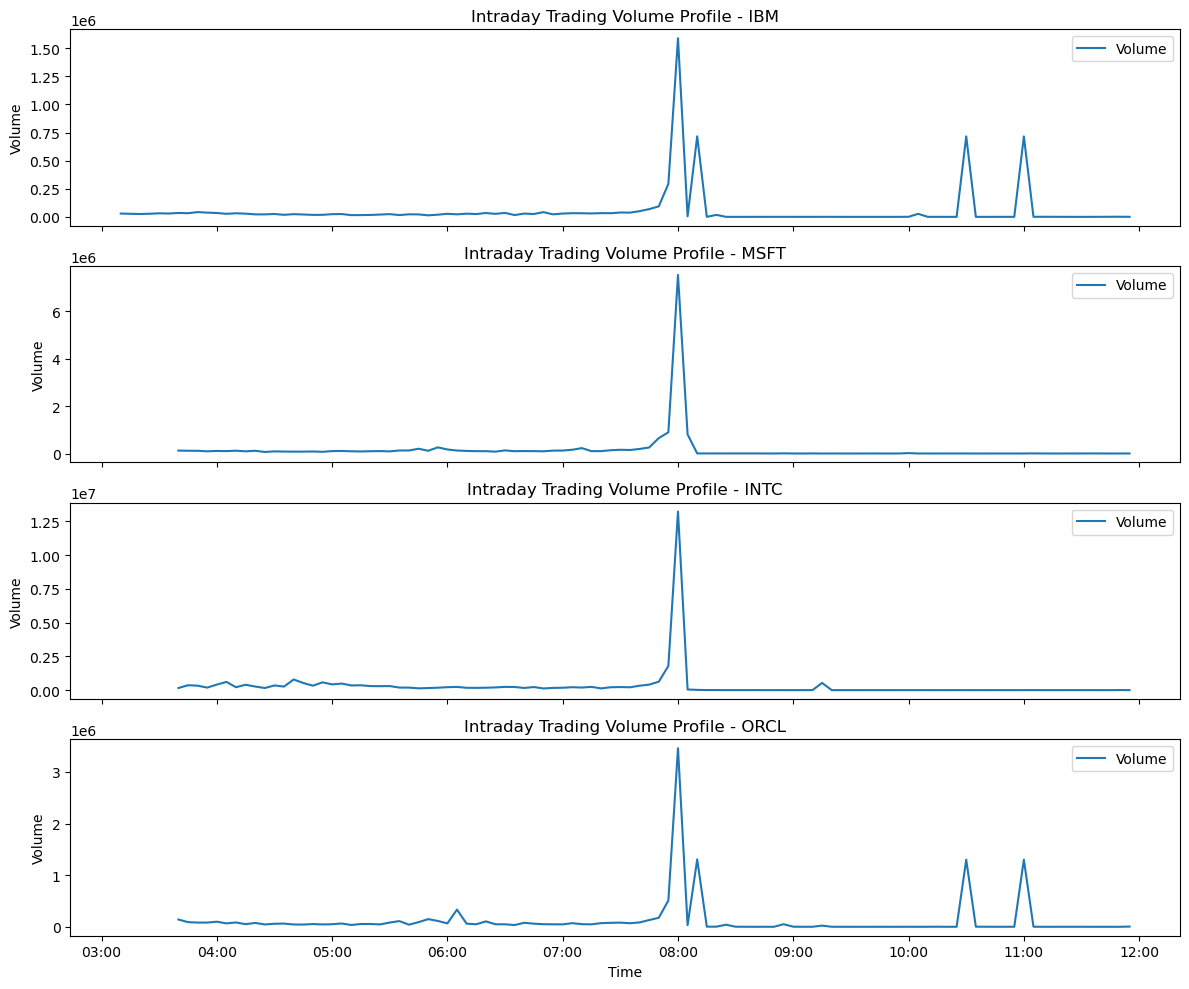

In [4]:
fig, axes = plt.subplots(nrows=len(df_list), ncols=1, figsize=(12, 10), sharex=True)

for i, (df, symbol) in enumerate(zip(df_list, ['IBM', 'MSFT', 'INTC', 'ORCL'])):
    ax = axes[i]
    sns.lineplot(x='Datetime', y='volume', data=df, label='Volume', ax=ax)
    ax.set_title(f'Intraday Trading Volume Profile - {symbol}')
    ax.set_ylabel('Volume')

    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

## 3.What is the percentage distribution of total trading volume among the four stocks?

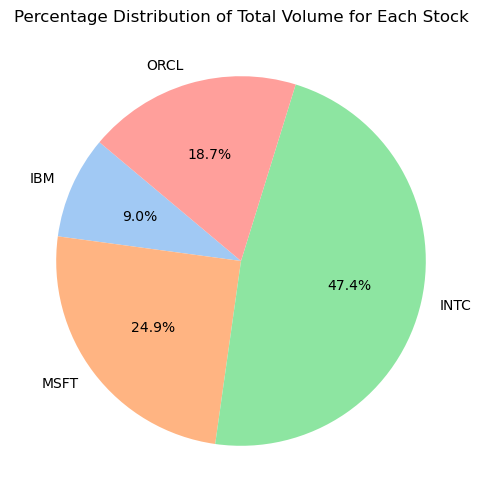

In [5]:
combined_volume = pd.concat([dfs['table_IBM']['volume'], dfs['table_MSFT']['volume'], dfs['table_INTC']['volume'], dfs['table_ORCL']['volume']], axis=1)
combined_volume.columns = ['IBM', 'MSFT', 'INTC', 'ORCL']

total_volume = combined_volume.sum()

plt.figure(figsize=(10, 6))
sns.set_palette("pastel")
plt.pie(total_volume, labels=total_volume.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Total Volume for Each Stock')
plt.show()

## 4. What is the percentage distribution of total daily returns among the four stocks?

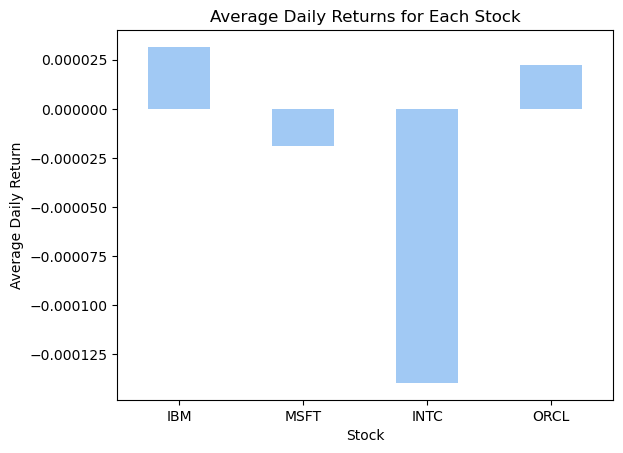

In [7]:
combined_returns = pd.concat([dfs['table_IBM']['daily_return'], dfs['table_MSFT']['daily_return'], dfs['table_INTC']['daily_return'], dfs['table_ORCL']['daily_return']], axis=1)
combined_returns.columns = ['IBM', 'MSFT', 'INTC', 'ORCL']

combined_returns.mean().plot(kind='bar')
plt.title('Average Daily Returns for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Average Daily Return')
plt.xticks(rotation=0)
plt.show()